# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install os
!pip install pandas 
!pip install torch
!pip install transformers 
!pip install peft 
!pip install datasets 
!pip install pickle
!pip install --user pandas


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [3]:
!pip install pandas
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

Defaulting to user installation because normal site-packages is not writeable


/home/ab12660/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer and Preprocess Data

In [4]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [5]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [7]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [8]:
# PEFT Config
# Replace old LoRA config with this
peft_config = LoraConfig(
    r=10,                          # Try r=10 for stronger adaptation
    lora_alpha=40,               # Stronger low-rank scaling
    lora_dropout=0.05,
    bias='none',
    target_modules=["query", "value"],  # Include both query and value projection
    task_type="SEQ_CLS"
)


In [9]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [10]:
 print("Trainable parameters:")
 for name, param in peft_model.named_parameters():
     if param.requires_grad:
         print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.sel

In [11]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 962,308 || all params: 125,611,016 || trainable%: 0.7661


## Training Setup

In [12]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [13]:
# Setup Training args
output_dir = "results"
# Better training setup
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    optim="adamw_torch",
    logging_dir="./logs",
    report_to=None
)




def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [14]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.265600,0.324273,0.900000
2,0.245200,0.268220,0.914062
3,0.217600,0.242825,0.928125
4,0.208900,0.234309,0.926562
5,0.202100,0.230531,0.931250
6,0.193800,0.236640,0.925000


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [15]:
 def classify(model, tokenizer, text):
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
     output = model(**inputs)

     prediction = output.logits.argmax(dim=-1).item()

     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
     return id2label[prediction]

In [16]:
 classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
 classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 0, Label: World, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [17]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [18]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:01<00:00, 49.58it/s]

Evaluation Metric: {'accuracy': 0.93125}


In [19]:
# Print final evaluation accuracy
final_eval = peft_lora_finetuning_trainer.evaluate()
print(f"\n✅ Final Eval Accuracy: {final_eval['eval_accuracy']:.4f}")

# Show number of parameters
peft_model.print_trainable_parameters()



✅ Final Eval Accuracy: 0.9313
trainable params: 962,308 || all params: 125,611,016 || trainable%: 0.7661


### Run Inference on unlabelled dataset

In [20]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:05<00:00, 1429.69 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [21]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:18<00:00, 54.10it/s]


Inference complete. Predictions saved to inference_output.csv


In [22]:
# Save model and tokenizer for reproducibility
peft_model.save_pretrained("./results/final_lora_model")
tokenizer.save_pretrained("./results/final_lora_model")


('./results/final_lora_model/tokenizer_config.json',
 './results/final_lora_model/special_tokens_map.json',
 './results/final_lora_model/vocab.json',
 './results/final_lora_model/merges.txt',
 './results/final_lora_model/added_tokens.json')

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def print_metrics(y_true, y_pred, dataset_name=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n=== {dataset_name} Metrics ===")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    return acc, prec, rec, f1

In [25]:
# Utility function to extract predictions and labels from a dataset
from torch.utils.data import DataLoader

def get_predictions(model, dataset, batch_size=8, data_collator=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    for batch in dataloader:
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        with torch.no_grad():
            outputs = model(**inputs)
        preds = outputs.logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


In [26]:
train_labels, train_preds = get_predictions(peft_model, train_dataset, data_collator=data_collator)
test_labels, test_preds = get_predictions(peft_model, eval_dataset, data_collator=data_collator)



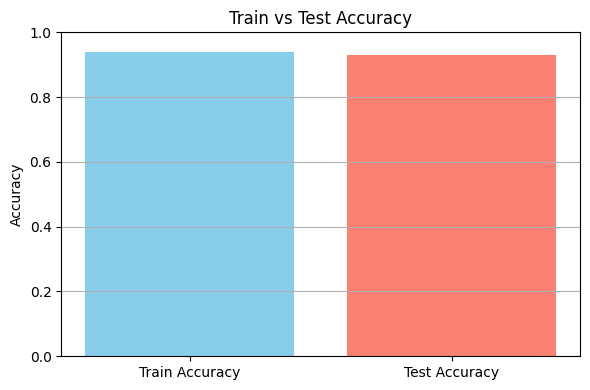

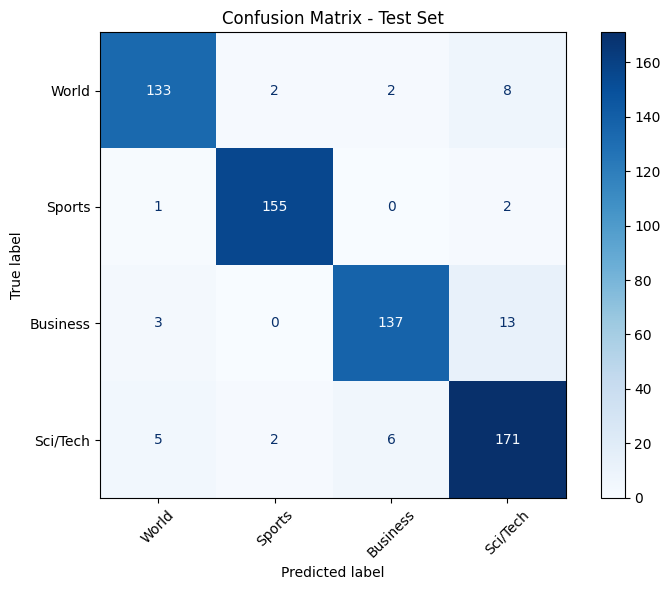

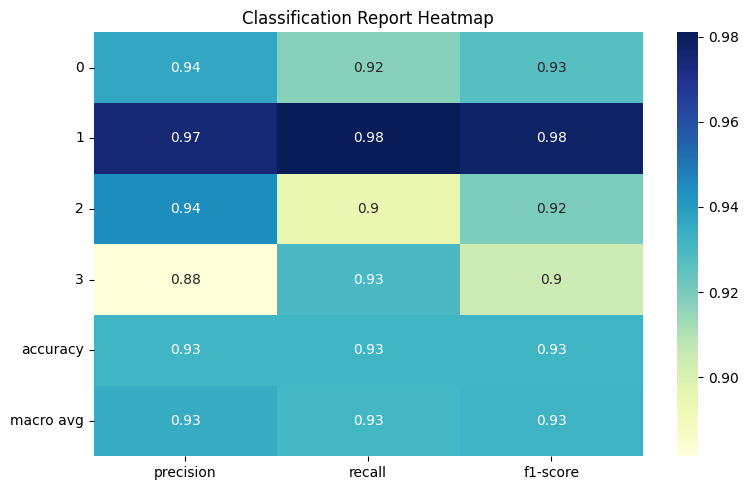

In [32]:
# Run this code after getting predictions to generate plots

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Accuracy comparison
train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)

plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("train_vs_test_accuracy.png")
plt.show()

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig("confusion_matrix_test_set.png")
plt.show()

# Classification report heatmap
report = classification_report(test_labels, test_preds, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1, :-1].T
plt.figure(figsize=(8, 5))
sns.heatmap(df_report, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.savefig("classification_report_heatmap.png")
plt.show()


In [28]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 1.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 53.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 2.8 MB/s eta 0:00:00ta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [31]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.2 MB/s eta 0:00:00a 0:00:01


In [33]:
# Get the logs stored by the Trainer
log_history = peft_lora_finetuning_trainer.state.log_history

# Extract accuracy values per epoch
train_accs = []
eval_accs = []
epochs = []

for entry in log_history:
    if 'eval_accuracy' in entry:
        eval_accs.append(entry['eval_accuracy'])
        epochs.append(entry['epoch'])
    if 'train_accuracy' in entry:  # Only if training accuracy is logged
        train_accs.append(entry['train_accuracy'])  # Optional; might be missing

# Optional: manually insert training accuracy if it's missing
if not train_accs:
    train_accs = [None] * len(eval_accs)


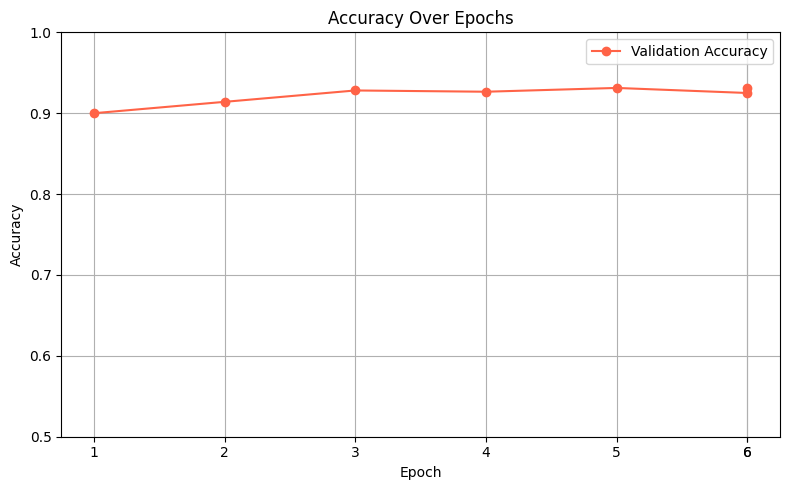

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_accs, label='Validation Accuracy', marker='o', color='tomato')
if any(train_accs):
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o', color='skyblue')

plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_vs_epoch.png")  # For your report
plt.show()


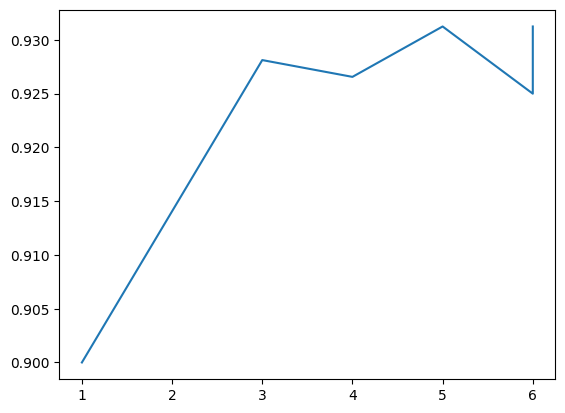

In [35]:
plt.plot(epochs, eval_accs, label='Validation Accuracy')


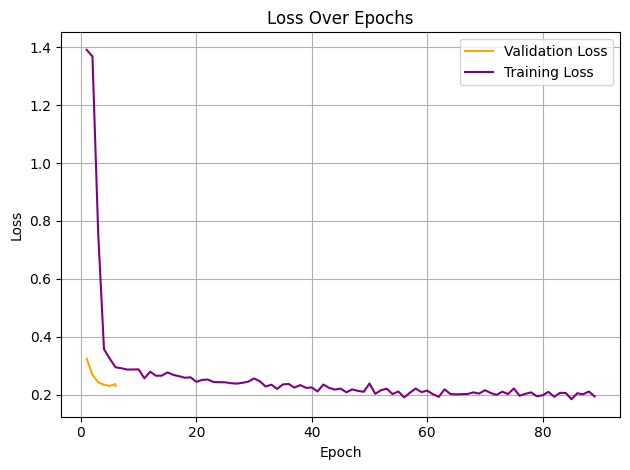

In [36]:
train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
epochs_loss = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]

plt.plot(epochs_loss, eval_losses, label='Validation Loss', color='orange')
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='purple')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png")
plt.show()


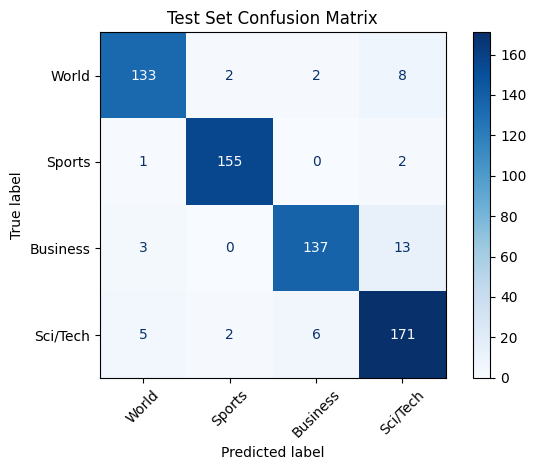

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


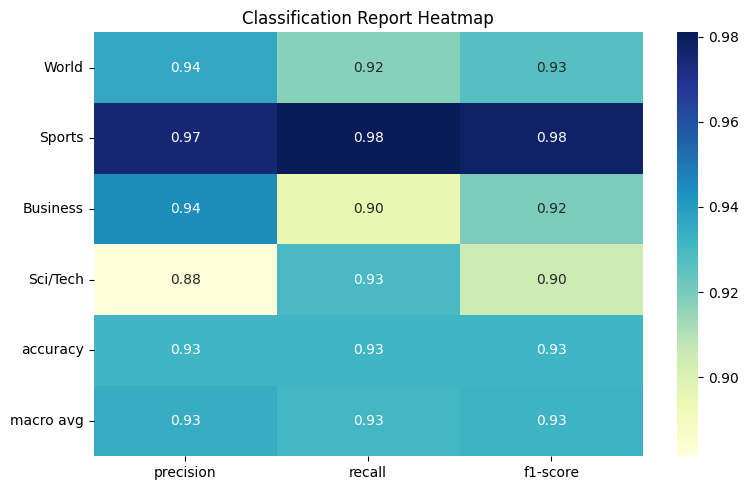

In [38]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv")

# Optional visualization:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.savefig("classification_report_heatmap.png")
plt.show()


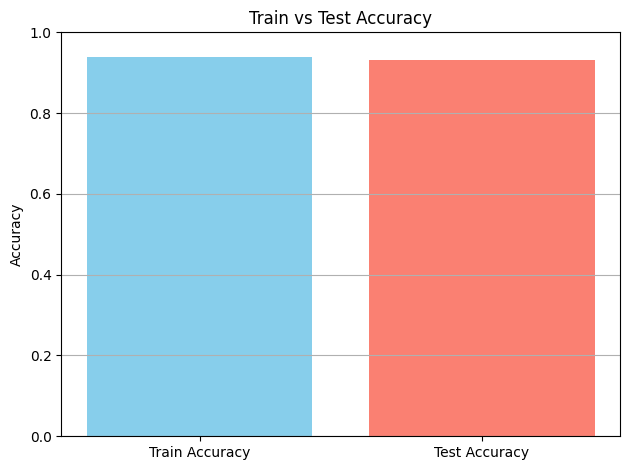

In [39]:
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("train_vs_test_accuracy.png")
plt.show()


In [40]:
examples = [
    "NASA launches a new satellite into orbit.",
    "Stocks rally as Fed pauses interest rate hikes.",
    "Manchester United defeats Liverpool in derby match.",
    "New AI model breaks records in image generation."
]

for sentence in examples:
    pred = classify(peft_model, tokenizer, sentence)
    print(f"Text: {sentence}\n → Predicted: {pred}\n")



 Class: 3, Label: Sci/Tech, Text: NASA launches a new satellite into orbit.
Text: NASA launches a new satellite into orbit.
 → Predicted: Sci/Tech


 Class: 2, Label: Business, Text: Stocks rally as Fed pauses interest rate hikes.
Text: Stocks rally as Fed pauses interest rate hikes.
 → Predicted: Business


 Class: 1, Label: Sports, Text: Manchester United defeats Liverpool in derby match.
Text: Manchester United defeats Liverpool in derby match.
 → Predicted: Sports


 Class: 3, Label: Sci/Tech, Text: New AI model breaks records in image generation.
Text: New AI model breaks records in image generation.
 → Predicted: Sci/Tech

